In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'danger': '#D64933',
    'info': '#6C63FF',
    'warning': '#FFB703'
}

In [ ]:
df_fe = pd.read_csv(r'D:\AI\ai2-project\data\1553768847-housing.csv')

print(f"Dataset Shape: {df_fe.shape[0]} rows - {df_fe.shape[1]} columns")
print(f"Memory Usage: {df_fe.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset Shape: 20640 rows - 10 columns
Memory Usage: 2.54 MB


In [44]:
df_fe['rooms_per_household'] = df_fe['total_rooms'] / df_fe['households']
df_fe['bedrooms_per_room'] = df_fe['total_bedrooms'] / df_fe['total_rooms']
df_fe['population_per_household'] = df_fe['population'] / df_fe['households']
df_fe['bedroom_ratio'] = df_fe['total_bedrooms'] / df_fe['total_rooms']

df_fe = df_fe.replace([np.inf, -np.inf], np.nan)

In [45]:
new_features = ['rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'bedroom_ratio']
display(df_fe[new_features].describe())

,rooms_per_household,bedrooms_per_room,population_per_household,bedroom_ratio
count,20640.000,20433.000,20640.000,20433.000
mean,5.429,0.213,3.071,0.213
std,2.474,0.058,10.386,0.058
min,0.846,0.100,0.692,0.100
25%,4.441,0.175,2.430,0.175
50%,5.229,0.203,2.818,0.203
75%,6.052,0.240,3.282,0.240
max,141.909,1.000,1243.333,1.000


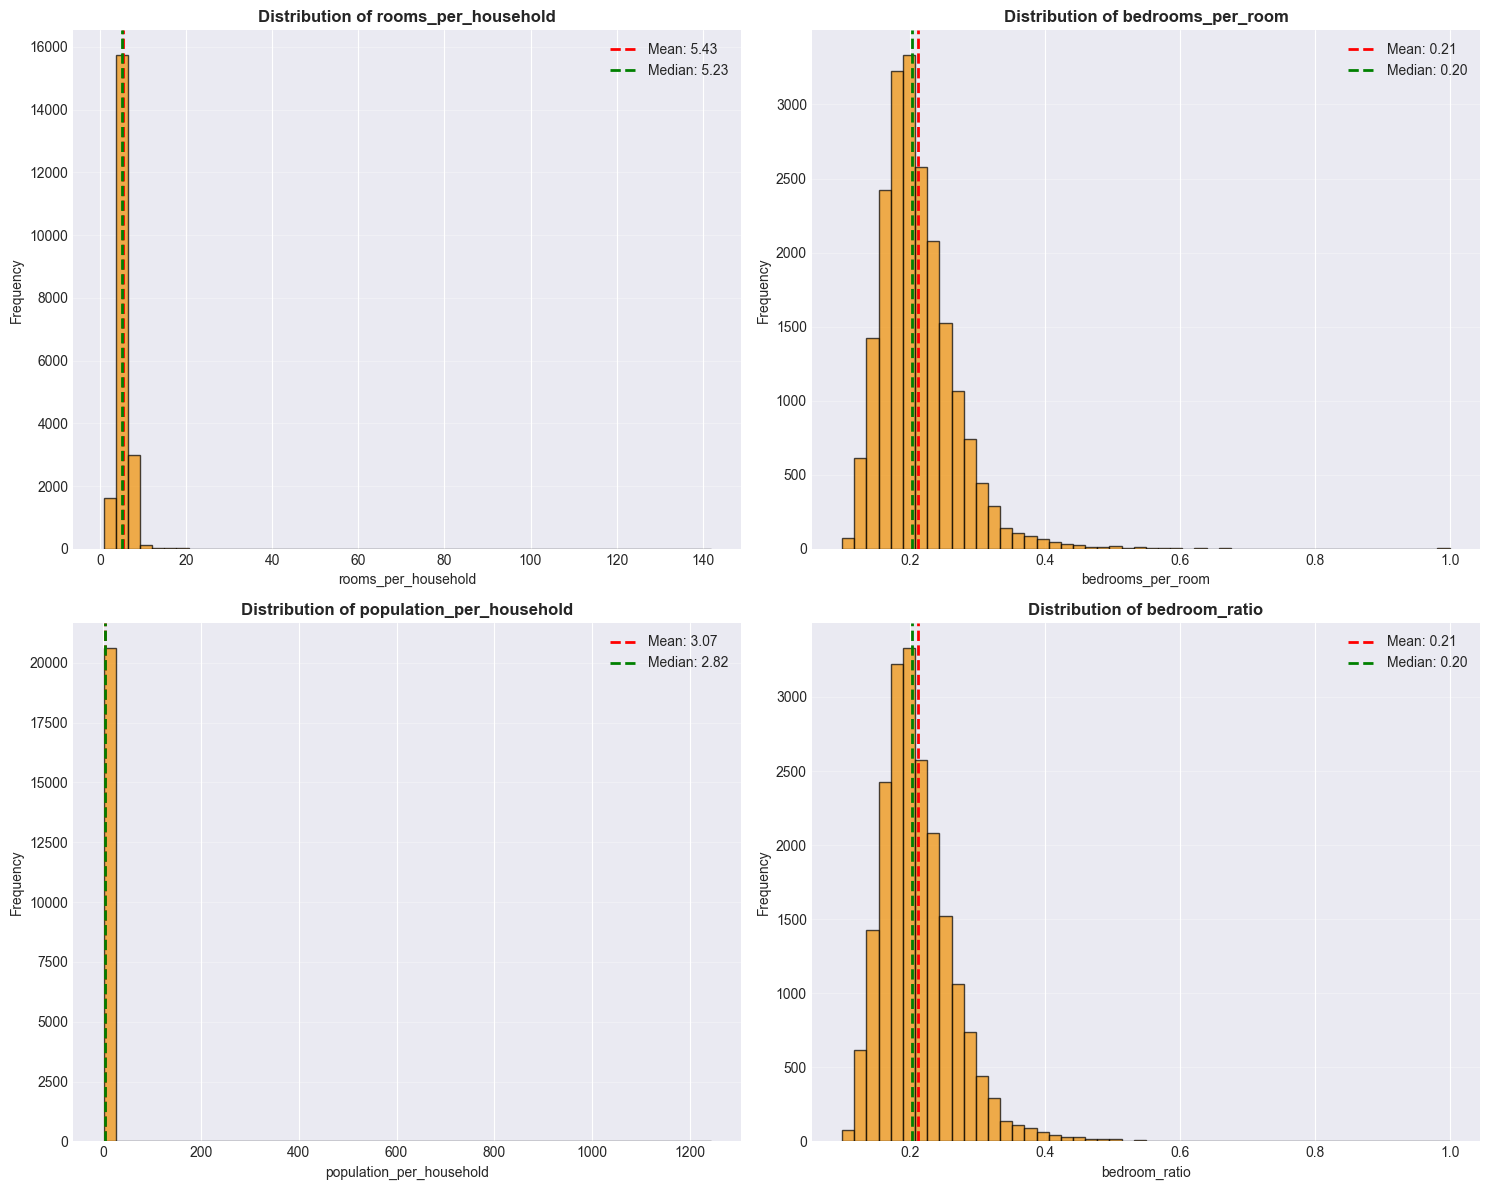

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(new_features):
    ax = axes[idx]
    
    ax.hist(df_fe[feature].dropna(), bins=50, color=COLORS['accent'], 
            alpha=0.7, edgecolor='black')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature}', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add statistics
    mean_val = df_fe[feature].mean()
    median_val = df_fe[feature].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

In [47]:
new_corr = df_fe[new_features + ['median_house_value']].corr()['median_house_value'].drop('median_house_value')

new_corr.sort_values(ascending=False)

rooms_per_household         0.152
population_per_household   -0.024
bedrooms_per_room          -0.256
bedroom_ratio              -0.256
Name: median_house_value, dtype: float64

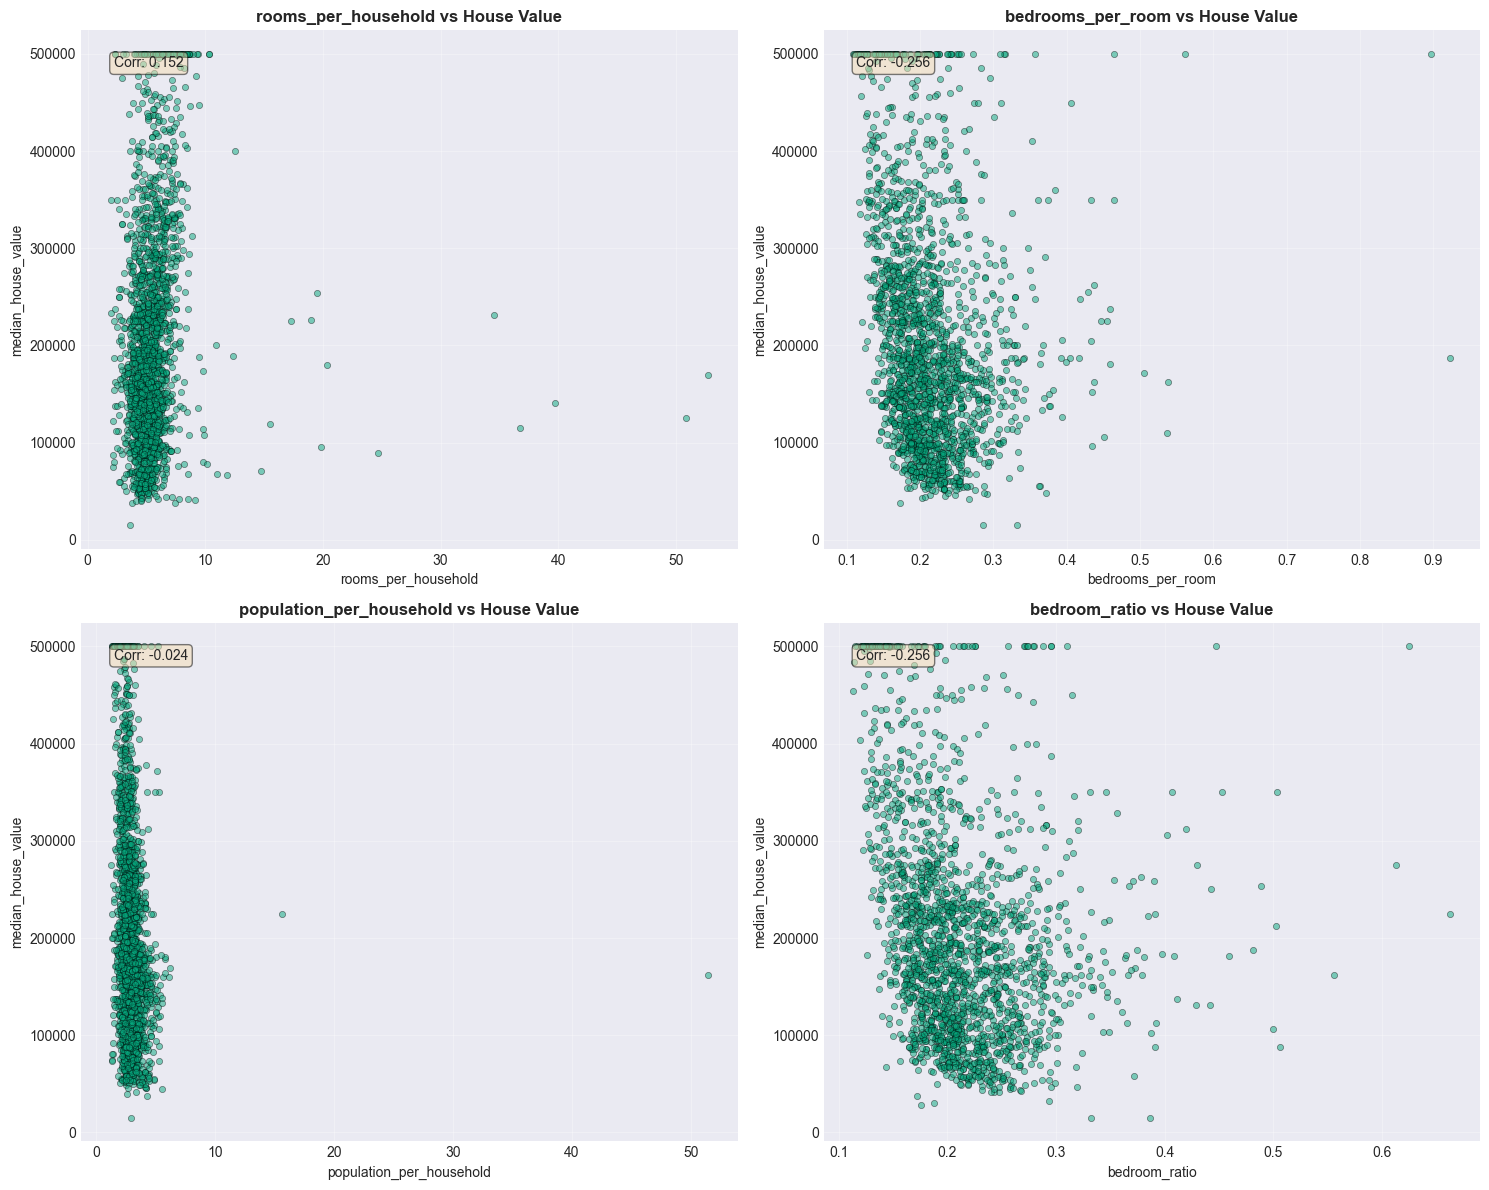

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(new_features):
    ax = axes[idx]
    
    sample_fe = df_fe.sample(min(2000, len(df_fe)))
    ax.scatter(sample_fe[feature], sample_fe['median_house_value'], 
               alpha=0.5, c=COLORS['success'], s=20, edgecolors='black', linewidth=0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel('median_house_value')
    ax.set_title(f'{feature} vs House Value', fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add correlation
    corr = df_fe[[feature, 'median_house_value']].corr().iloc[0, 1]
    ax.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [49]:
numeric_cols = df_fe.select_dtypes(include=[np.number]).columns.tolist()

def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data.dropna()))
    return np.sum(z_scores > threshold)

# IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.sum((data < lower_bound) | (data > upper_bound))

outlier_analysis = pd.DataFrame({
    'Z-Score Outliers (>3)': [detect_outliers_zscore(df_fe[col]) for col in numeric_cols],
    'IQR Outliers': [detect_outliers_iqr(df_fe[col]) for col in numeric_cols],
    'Z-Score %': [(detect_outliers_zscore(df_fe[col])/len(df_fe)*100) for col in numeric_cols],
    'IQR %': [(detect_outliers_iqr(df_fe[col])/len(df_fe)*100) for col in numeric_cols]
}, index=numeric_cols)

display(outlier_analysis.round(2))


,Z-Score Outliers (>3),IQR Outliers,Z-Score %,IQR %
longitude,0,0,0.000,0.000
latitude,0,0,0.000,0.000
housing_median_age,0,0,0.000,0.000
total_rooms,373,1287,1.810,6.240
total_bedrooms,370,1271,1.790,6.160
population,342,1196,1.660,5.790
households,363,1220,1.760,5.910
median_income,345,681,1.670,3.300
median_house_value,0,1071,0.000,5.190
rooms_per_household,133,511,0.640,2.480


In [51]:
normality_results = []
for col in numeric_cols:
    data_sample = df_fe[col].dropna().sample(min(5000, len(df_fe[col].dropna())))
    stat, p_value = stats.shapiro(data_sample)
    normality_results.append({
        'Feature': col,
        'Statistic': stat,
        'P-Value': p_value,
        'Normal?': 'Yes' if p_value > 0.05 else 'No'
    })

normality_df = pd.DataFrame(normality_results)
display(normality_df)

,Feature,Statistic,P-Value,Normal?
0,longitude,0.895,0.000,No
1,latitude,0.878,0.000,No
2,housing_median_age,0.980,0.000,No
3,total_rooms,0.723,0.000,No
4,total_bedrooms,0.739,0.000,No
5,population,0.742,0.000,No
6,households,0.751,0.000,No
7,median_income,0.888,0.000,No
8,median_house_value,0.909,0.000,No
9,rooms_per_household,0.474,0.000,No


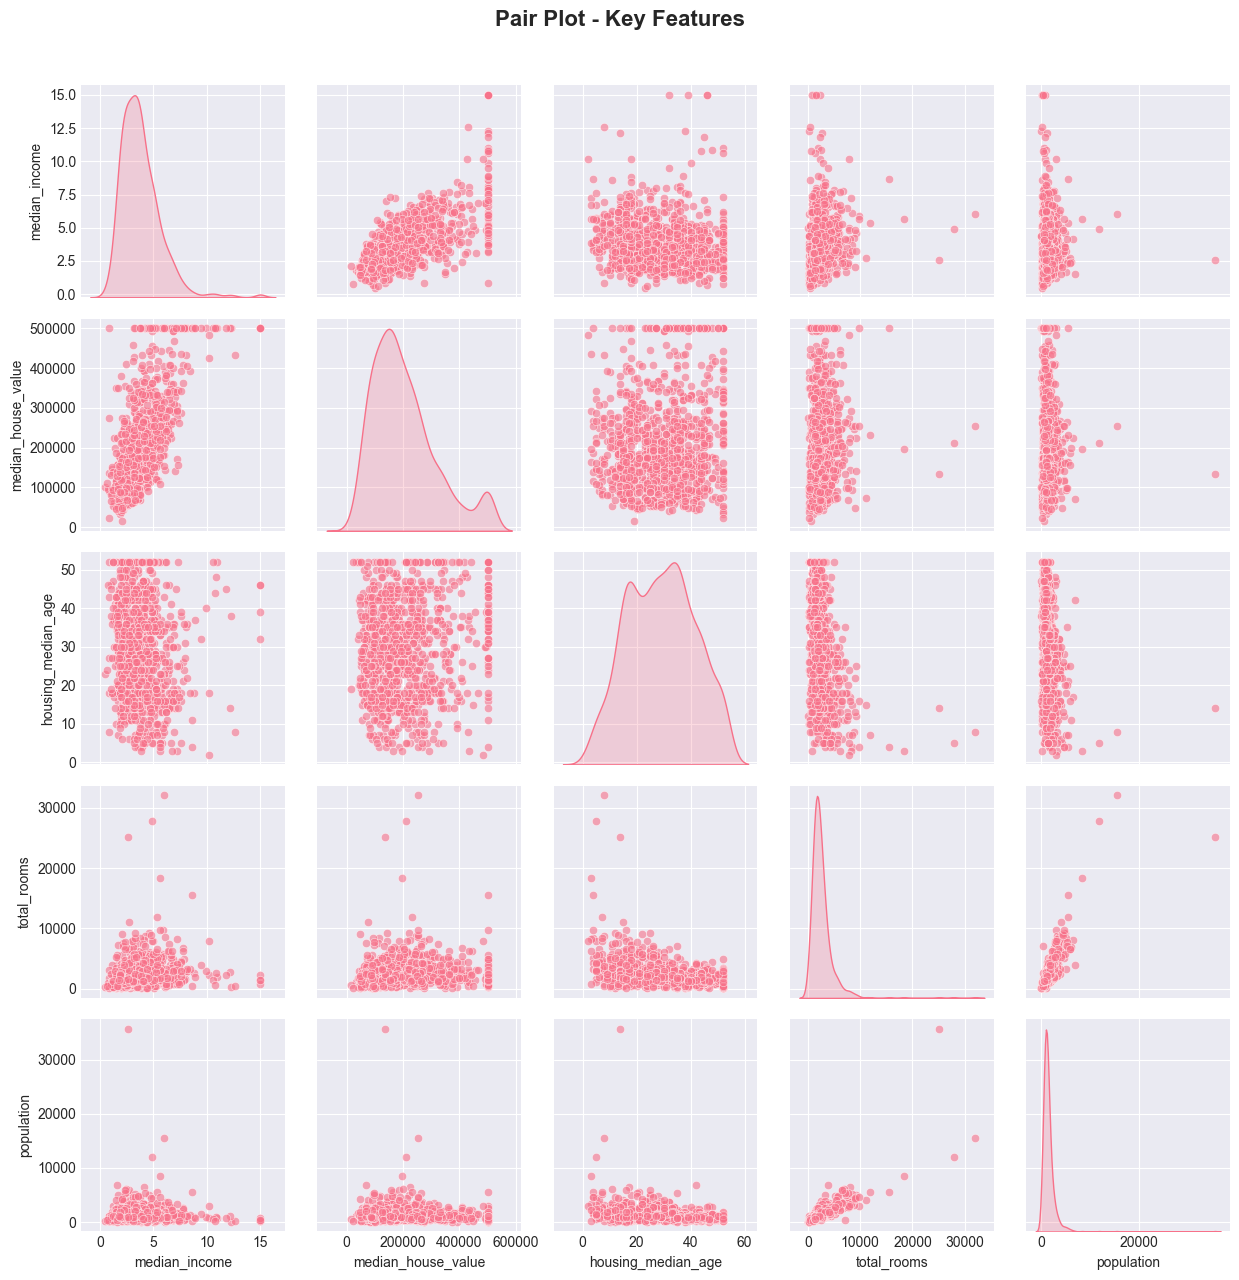

In [ ]:
key_features_pair = ['median_income', 'median_house_value', 'housing_median_age', 
                     'total_rooms', 'population']

sample_pair = df_fe[key_features_pair].sample(min(1000, len(df_fe)))

pair_plot = sns.pairplot(sample_pair, diag_kind='kde', plot_kws={'alpha': 0.6})
pair_plot.fig.suptitle('Pair Plot - Key Features', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()